In [1]:
import numpy as np
import pandas as pd

In [18]:
from google.colab import auth, drive
from google.auth import default

auth.authenticate_user()
drive.mount('/content/drive/', force_remount=True)

data = pd.read_csv('/content/drive/My Drive/aml_project/data.csv')

Mounted at /content/drive/


In [19]:
data.head()

,Unnamed: 0,^GSPC,^TNX,Date,Ticker,Price_Stock,Price_Log_Return,polarity_score
0,0,0.005053,0.062507,2022-03-25,AAPL,174.720001,0.003727,0.140153
1,1,0.007120,-0.006037,2022-03-28,AAPL,175.600006,0.005024,0.199839
2,2,0.012182,-0.031579,2022-03-29,AAPL,178.960007,0.018954,0.220375
3,3,-0.006314,-0.017655,2022-03-30,AAPL,177.770004,-0.006672,0.183917
4,4,-0.015776,-0.013234,2022-03-31,AAPL,174.610001,-0.017936,0.213395


<Axes: >

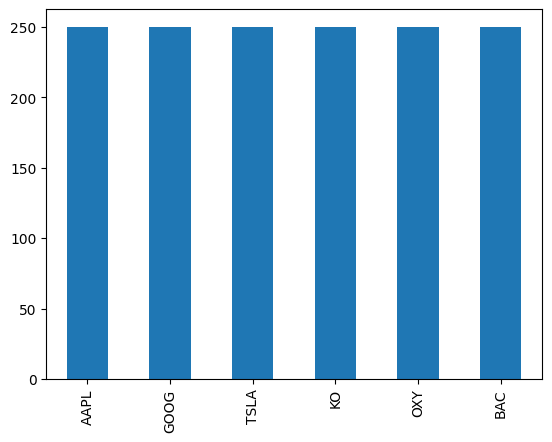

In [20]:
data['Ticker'].value_counts().plot(kind = 'bar')

In [21]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(data[['Ticker']]).toarray())
final_df = data.join(encoder_df)

In [22]:
final_df

,Unnamed: 0,^GSPC,^TNX,Date,Ticker,Price_Stock,Price_Log_Return,polarity_score,0,1,2,3,4,5
0,0,0.005053,0.062507,2022-03-25,AAPL,174.720001,0.003727,0.140153,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0.007120,-0.006037,2022-03-28,AAPL,175.600006,0.005024,0.199839,1.0,0.0,0.0,0.0,0.0,0.0
2,2,0.012182,-0.031579,2022-03-29,AAPL,178.960007,0.018954,0.220375,1.0,0.0,0.0,0.0,0.0,0.0
3,3,-0.006314,-0.017655,2022-03-30,AAPL,177.770004,-0.006672,0.183917,1.0,0.0,0.0,0.0,0.0,0.0
4,4,-0.015776,-0.013234,2022-03-31,AAPL,174.610001,-0.017936,0.213395,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1495,-0.011081,-0.054455,2023-03-17,BAC,27.820000,-0.040506,0.156767,0.0,1.0,0.0,0.0,0.0,0.0
1496,1496,0.008879,0.025016,2023-03-20,BAC,27.750000,-0.002519,0.144080,0.0,1.0,0.0,0.0,0.0,0.0
1497,1497,0.012899,0.035280,2023-03-21,BAC,28.590000,0.029821,0.239337,0.0,1.0,0.0,0.0,0.0,0.0
1498,1498,-0.016600,-0.029836,2023-03-22,BAC,27.639999,-0.033793,0.282973,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
df = final_df.drop(columns=['Unnamed: 0', 'Ticker', 'Price_Log_Return'])


In [30]:
#train/val/test split

train = df.loc[df['Date'] < "2022-12-01"]
#val = df.loc[(df['Date'] >= "2022-12-01") & (df['Date'] < "2023-01-23")]
test =  df.loc[df['Date'] >= "2023-01-23"]

In [31]:
train = train.drop(columns=['Date'])
#val = val.drop(columns=['Date'])
test = test.drop(columns=['Date'])
#val

In [32]:
#X/y split

train_y = train['Price_Stock'].copy()
train_X = train.drop(['Price_Stock'], 1)

#val_y = val['Price_Stock'].copy()
#val_X = val.drop(['Price_Stock'], 1)

test_y = test['Price_Stock'].copy()
test_X = test.drop(['Price_Stock'], 1)


<ipython-input-32-1dbe00af4a7e>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_X = train.drop(['Price_Stock'], 1)
<ipython-input-32-1dbe00af4a7e>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_X = test.drop(['Price_Stock'], 1)


In [48]:
#split test data based on ticker

ticker_names = ['AAPL', 'GOOG', 'TSLA', 'KO', 'OXY', 'BAC']
test_X_arr = []
test_y_arr = []

for i in range(6):
  idx = 43*i
  test_X_arr.append(test_X.iloc[idx:idx+43])
  test_y_arr.append(test_y.iloc[idx:idx+43])


In [36]:
#Grid Search

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

params = {
    'random_state': [42],
    'max_depth': [3,4,5,10],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.05],
    'gamma': [0.0001, 0.001, 0.005, 0.01, 0.02, 0.03]
}

model = xgb.XGBRegressor(objective='reg:squarederror')

gs = GridSearchCV(model, param_grid=params)

gs.fit(train_X, train_y)

print('Best Params:', gs.best_params_)
print('Best Val Score:', gs.best_score_)

Best Params: {'gamma': 0.02, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 400, 'random_state': 42}
Best Val Score: -6.449913879340757


In [37]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#train with best params, test

model = xgb.XGBRegressor(**gs.best_params_, objective='reg:squarederror')
model.fit(train_X, train_y)

score = model.score(train_X, train_y)  
print("training score: ", score)

preds = model.predict(test_X)
mse = mean_squared_error(test_y, preds)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))


training score:  0.9881579046296172
MSE: 1078.75
RMSE: 32.84


In [40]:
#Grid Search

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

params = {
    'random_state': [42],
    'max_depth': [3,4,5,6,10],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1],
    'gamma': [0.0001, 0.001, 0.005, 0.01, 0.02, 0.03]
}

model = xgb.XGBRegressor(objective='reg:squarederror')

gs = GridSearchCV(model, param_grid=params)

gs.fit(train_X, train_y)

print('Best Params:', gs.best_params_)
#print('Best Val Score:', gs.best_score_)

Best Params: {'gamma': 0.0001, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'random_state': 42}


In [41]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#train with best params, test

model = xgb.XGBRegressor(**gs.best_params_, objective='reg:squarederror')
model.fit(train_X, train_y)

score = model.score(train_X, train_y)  
print("training score: ", score)

preds = model.predict(test_X)
mse = mean_squared_error(test_y, preds)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

training score:  0.9407971481870573
MSE: 697.48
RMSE: 26.41


In [68]:
# test for each ticker

for i in range(6):
  preds = model.predict(test_X_arr[i])
  mse = mean_squared_error(test_y_arr[i], preds)
  print(ticker_names[i])
  print("MSE: %.2f" % mse)
  print("RMSE: %.2f" %(mse**(1/2.0)))
  print()

AAPL
MSE: 60.50
RMSE: 7.78

GOOG
MSE: 88.78
RMSE: 9.42

TSLA
MSE: 4016.89
RMSE: 63.38

KO
MSE: 1.09
RMSE: 1.04

OXY
MSE: 8.64
RMSE: 2.94

BAC
MSE: 9.00
RMSE: 3.00



AAPL


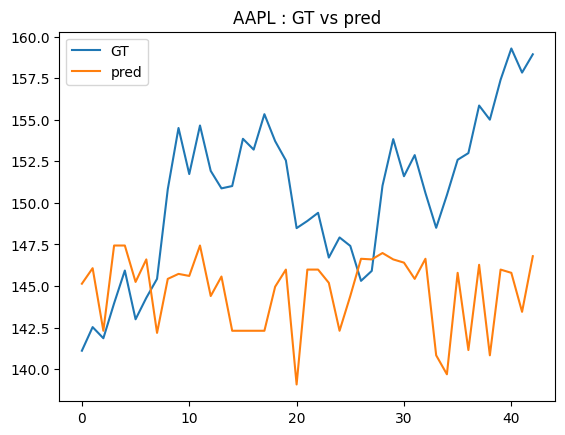

GOOG


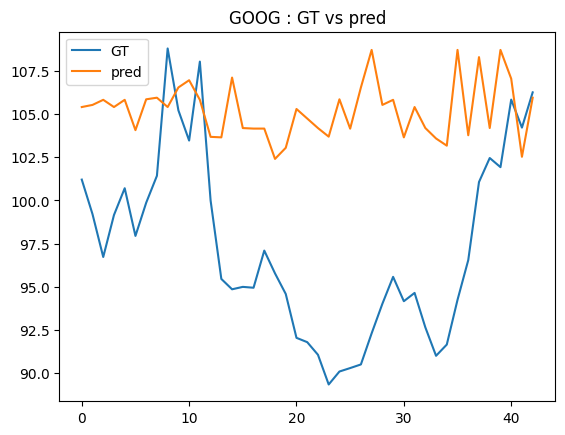

TSLA


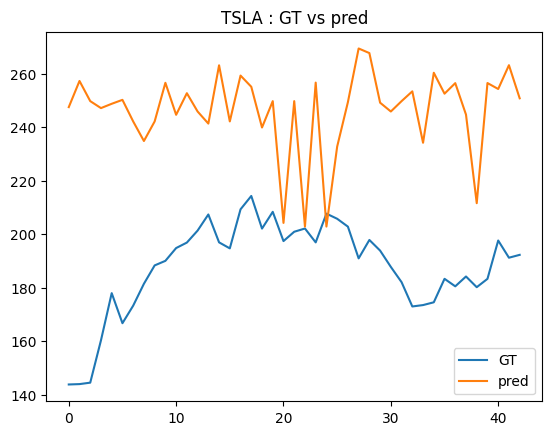

KO


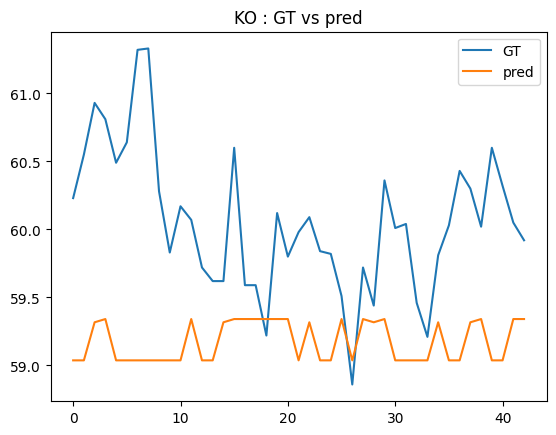

OXY


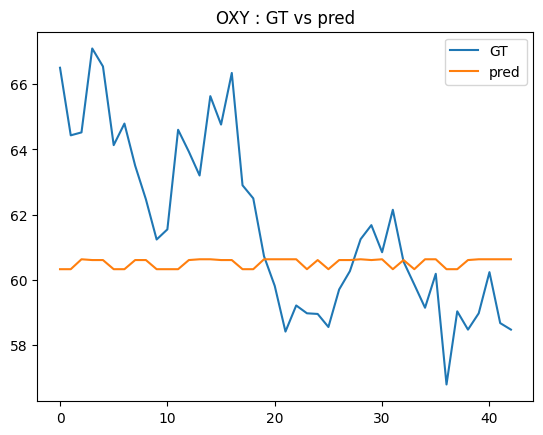

BAC


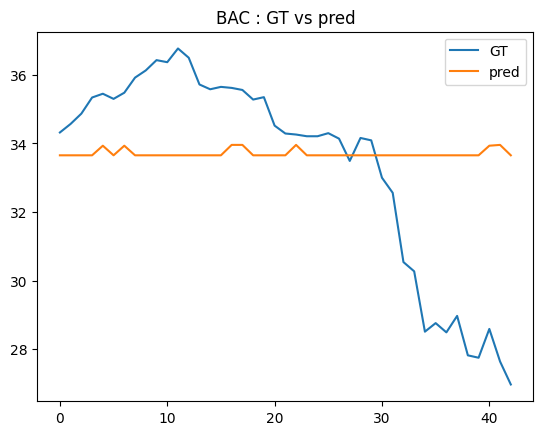

In [62]:
# plot for each ticker

for i in range(6):
  preds = model.predict(test_X_arr[i])
  mse = mean_squared_error(test_y_arr[i], preds)

  ax = range(43)
  plt.plot(ax, test_y_arr[i], label="GT")
  plt.plot(ax, preds, label="pred")
  plt.title(ticker_names[i]+ " : GT vs pred")
  plt.legend()
  plt.show()



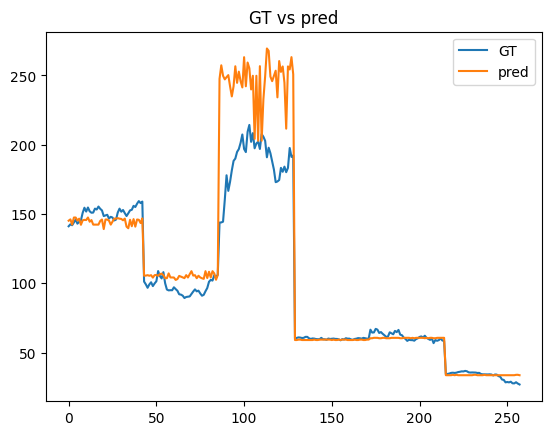

In [54]:
#plot results _ all stocks

ax = range(len(test_y))
plt.plot(ax, test_y, label="GT")
plt.plot(ax, preds, label="pred")
plt.title("GT vs pred")
plt.legend()
plt.show()

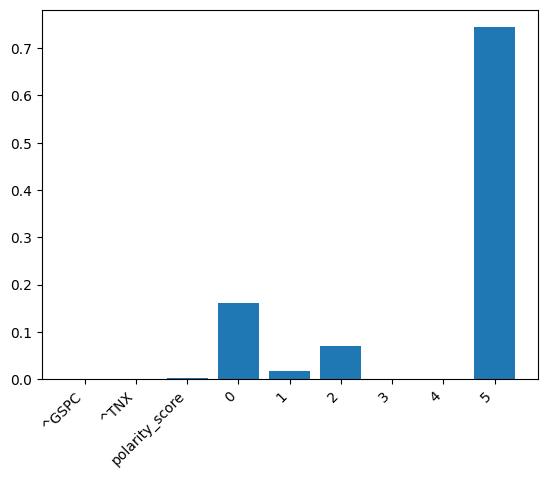

In [69]:
# plot feature importance

features = model.get_booster().feature_names
y = np.arange(len(features))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(y, model.get_booster().feature_names, rotation=45, fontsize='10', horizontalalignment='right')
plt.show()